In [1]:
####### All Imports #######
import warnings
warnings.filterwarnings("ignore")

import os
import random
from datetime import datetime

import librosa
from scipy.io import wavfile
import numpy as np
import pandas as pd
import sklearn as sk
import torch
from torch.utils import data
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
####### Setup Environment #######

# enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# (tf v2) - allowing GPU memory growth.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
      # Memory growth must be set before GPUs have been initialized
      print(e)

#keras saving/loading issue attempt?
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
# manual_variable_initialization(True)

1 Physical GPUs, 1 Logical GPUs


In [3]:
####### Configs for Machine Learning #######

### Loading Test/Training Data ###
load_urbansound_data = True # <-- Note: Urbansound8k has a shortcut for testing/debugging, only loads 1 folder (800 instead of 8000)
# Data Source: https://urbansounddataset.weebly.com/urbansound8k.html
load_birds_data      = False
# Data Source: http://machine-listening.eecs.qmul.ac.uk/bird-audio-detection-challenge/#downloads
load_kaggle_data     = False
# Data Source: https://www.kaggle.com/mmoreaux/environmental-sound-classification-50#esc50.csv
load_audioset_data   = False
# Data Source: https://research.google.com/audioset/index.html
# See scripts/README.md for downloading & filtering instructions.


### Loading/Saving Model ###
load_model_file = False # False = create new model, String = load pre-trian model from filename (no filename extension).
save_model_file = False # False = do nothing, String = save trained model to filename (no filename extension).
# save_model_file = "urbansound_first_try" 
# load_model_file = "urbansound_first_try"


### Training / Fitting / Optimizing Model #####
test_size = 0.2
epochs    = 100
batch_size= 10
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [4]:
####### HELPER FUNCTIONS (Table of Content) #######
# extract_features
# load_all_wav_files
# analyze_features
# plot_history (loss & accuracy v epochs)
# plot_confusion_matrix

In [5]:
def extract_features(file_name):
    """
    Extracts 193 chromatographic features from sound file. 
    including: MFCC's, Chroma_StFt, Melspectrogram, Spectral Contrast, and Tonnetz
    NOTE: this extraction technique changes the time series nature of the data
    """
    features = []
    
    audio_data, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(audio_data))
    
    mfcc = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T,axis=0)
    features.extend(mfcc) # 40 = 40
    
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    features.extend(chroma) # 12 = 52
    
    mel = np.mean(librosa.feature.melspectrogram(audio_data, sr=sample_rate).T,axis=0)
    features.extend(mel) # 128 = 180
    
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    features.extend(contrast) # 7 = 187

# More possible features to add
#     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X, ), sr=sample_rate).T,axis=0)
#     spec_cent = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate).T, axis=0)
#     spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate).T, axis=0)
#     rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate).T, axis=0)
#     zcr = np.mean(librosa.feature.zero_crossing_rate(audio_data).T, axis=0)
#     features.extend(tonnetz) # 6 = 193
#     features.extend(spec_cent)
#     features.extend(spec_bw)
#     features.extend(rolloff)
#     features.extend(zcr)

    return np.array(features)

In [6]:
from scipy.io import wavfile as wav

def display_wav(wav_file):
    librosa_load, librosa_sampling_rate = librosa.load(wav_file)
    scipy_sampling_rate, scipy_load = wav.read(wav_file)
    print('original sample rate:',scipy_sampling_rate)
    print('converted sample rate:',librosa_sampling_rate)
    print('\n')
    print('original wav file min~max range:',np.min(scipy_load),'~',np.max(scipy_load))
    print('converted wav file min~max range:',np.min(librosa_load),'~',np.max(librosa_load))
    plt.figure(figsize=(12, 4))
    plt.plot(scipy_load)
    plt.figure(figsize=(12, 4))
    plt.plot(librosa_load)

In [7]:
def load_all_wav_files(load_urbansound=False,
                       load_birds=False,
                       load_kaggle=False,
                       load_audioset=False):
    '''
    Returns two numpy array
    The first is a numpy array containing each audio's numerical features - see extract_features()
    The second numpy array is the array *STRING* of the label.
    (The array indexes align up between the two arrays. data[idx] is classified as labels[idx]) 
    '''
    one_file = None
    #THIS WILL TAKE A WHILE!!!!!
    all_data = []
    all_labels = []
    #UltraSound8K
    if load_urbansound:
        print("loading Ultrasound8k")
        # Data Source: https://urbansounddataset.weebly.com/urbansound8k.html
        metadata = pd.read_csv("./data/UrbanSound8K/metadata/UrbanSound8K.csv")
        for root, dirs, files in os.walk("./data/UrbanSound8K"):
            print(root, str(len(dirs)), str(len(files)), len(all_data))
#SHORTCUT
# This is in here for quick tests - only loads first Ultrasound8k folder (instead of all of them)
            if len(all_data) > 0: 
                break
#END SHORTCUT
            for idx, file in enumerate(files):
                if file.endswith('.wav'):
                    fname = os.path.join(root, file)
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
                    features = extract_features(fname)
                    label = metadata[metadata.slice_file_name == file]["class"].tolist()[0]
                    all_data.append(features)
                    all_labels.append(label)
                    one_file = fname
#                     display_wav(fname)
#                     break


    if load_birds:
        print("Loading birds")
        # Data Source: http://dcase.community/challenge2018/task-bird-audio-detection
        # Data Source: http://machine-listening.eecs.qmul.ac.uk/bird-audio-detection-challenge/#downloads
        for root, dirs, files in os.walk("./data/warblrb10k_public_wav/train/hasbird"):
            print(root, str(len(dirs)), str(len(files)), len(all_data))
            for file in files:
                if file.endswith('.wav'):
                    fname = os.path.join(root, file)
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
                    features = extract_features(fname)
                    all_data.append(features)
                    all_labels.append("bird")


    if load_kaggle:
        print("Loading Kaggle")
        # Data Source: https://www.kaggle.com/mmoreaux/environmental-sound-classification-50#esc50.csv
        metadata = pd.read_csv("./data/environmental-sound-classification-50/esc50.csv")
        #for root, dirs, files in os.walk("./data/environmental-sound-classification-50/"):
        for file in os.listdir("./data/environmental-sound-classification-50/audio"):
            fname = "./data/environmental-sound-classification-50/audio/"+file
            if file.endswith('.wav'):
                label = metadata[metadata.filename == file]["category"].tolist()[0]
                animals=["cat", "chirping_birds","cow","crickets","crow","dog","frog","hen","insects","pig","rooster","sheep"]
                if label in animals:
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
                    features = extract_features(fname)
                    all_data.append(features)
                    all_labels.append(label)
    
    if load_audioset:
        # Data Source: https://research.google.com/audioset/index.html
        # See scripts/README.md for downloading & filtering instructions.
        print("Loading Audioset")
        metadata_b = pd.read_csv("./data/audioset/balanced_train_segments-animals.csv")
        metadata_e = pd.read_csv("./data/audioset/eval_segments-animals.csv")
        metadata_l = pd.read_csv("./data/audioset/class_labels_indices-animals.csv")
        for root, dirs, files in os.walk("./data/audioset"):
            print(root, str(len(dirs)), str(len(files)), len(all_data))
            for idx, file in enumerate(files):
                if file.endswith('.wav'):
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
                    fname = os.path.join(root, file)
                    features = extract_features(fname)
                    no_ext = file.replace(".wav", "")
                    temp = None
                    if "balanced_train_segments" in fname:
                        temp = metadata_b[metadata_b['# YTID'] == no_ext]["Unnamed: 3"].tolist()
                    elif "eval_segments" in fname:
                        temp = metadata_e[metadata_e['# YTID'] == no_ext]["Unnamed: 3"].tolist()
                    if not temp:
                        continue
                    label_code = temp[0]
                    label_temp = metadata_l[metadata.mid == label_code]["display_name"].to_list()
                    if not label_temp:
                        continue
                    label = label_temp[0]
                    
                    all_data.append(features)
                    all_labels.append(label)
        
    
    return np.array(all_data), np.array(all_labels), one_file

In [8]:
def analyze_features(all_data, all_labels):
    #seeking only the numeric features from the data
    numeric_features = all_data.select_dtypes(include = [np.number])
    print(numeric_features.dtypes)
    corr = numeric_features.corr()
    print(corr)
#     print(corr['SalePrice'].sort_values(ascending = False)[:5], '\n')
#     print(corr['SalePrice'].sort_values(ascending = False)[-5:])

In [9]:
def plot_history(history = None):
    # Plots accuracy & loss versus epochs
    if not history:
        print("No history to plot")
        return
    fig = plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], label="Loss")
    plt.plot(history.history['accuracy'], label="Accuracy")
    plt.axis([0,90,0,np.max(history.history['accuracy'])])
    plt.title("Accuracy and Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Percentage")
    plt.legend()
    plt.show()

In [10]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes,
           yticklabels=classes,
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(len(classes)-0.5, -0.5)
    ax.set_aspect('auto')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.show()

loading Ultrasound8k
./data/UrbanSound8K 2 3 0
./data/UrbanSound8K\audio 10 1 0
./data/UrbanSound8K\audio\fold1 0 874 0
0
100
200
300
400
500
600
700
800
./data/UrbanSound8K\audio\fold10 0 838 873
original sample rate: 8000
converted sample rate: 22050


original wav file min~max range: -24999 ~ 25014
converted wav file min~max range: -0.7963537 ~ 0.7628686


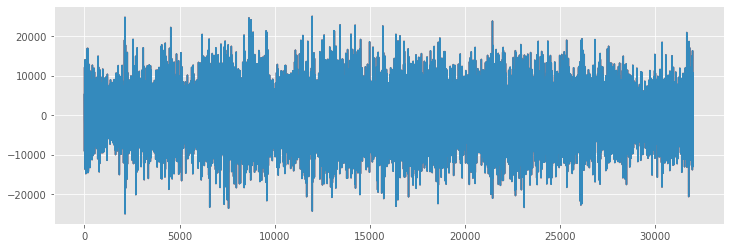

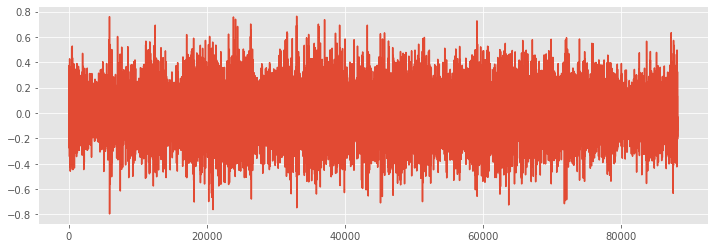

In [11]:
all_data, all_labels, one_file = load_all_wav_files(load_urbansound_data,
                                          load_birds_data,
                                          load_kaggle_data,
                                          load_audioset_data)
display_wav(one_file)

In [12]:
# analyze_features(all_data, all_labels)

In [13]:
print(all_data.shape)
classes = list(set(all_labels)) # classes = unique list of labels
n_classes = len(classes)
numeric_labels = np.array([classes.index(label) for label in all_labels]) # labels by index
print(classes)

(873, 187)
['drilling', 'jackhammer', 'engine_idling', 'car_horn', 'children_playing', 'gun_shot', 'dog_bark', 'siren', 'street_music', 'air_conditioner']


In [14]:
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(all_data, numeric_labels, test_size=test_size, shuffle=True)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(698, 187)
(698,)
(175, 187)
(175,)


In [15]:
model = Sequential()
model.add(Dense(256, activation='relu',  input_dim=x_train.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_classes, activation='softmax')) # sigmoid

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [16]:
history = None
if load_model_file:
    fpath = os.path.join("model", load_model_file + ".hdf5")
    model.load_weights(fpath)
elif save_model_file:
    fpath = os.path.join("model", save_model_file + ".hdf5")
    checkpointer = ModelCheckpoint(filepath=fpath,
                                   monitor='val_loss', 
                                   save_best_only=True,
                                   verbose=1)
    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpointer],
                        verbose=2)
else:
    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        verbose=2)

Train on 698 samples, validate on 175 samples
Epoch 1/100
 - 0s - loss: 4.2040 - accuracy: 0.4026 - val_loss: 1.3178 - val_accuracy: 0.6000
Epoch 2/100
 - 0s - loss: 0.8769 - accuracy: 0.7077 - val_loss: 0.9411 - val_accuracy: 0.7371
Epoch 3/100
 - 0s - loss: 0.5584 - accuracy: 0.8266 - val_loss: 0.4886 - val_accuracy: 0.8114
Epoch 4/100
 - 0s - loss: 0.5113 - accuracy: 0.8711 - val_loss: 0.6294 - val_accuracy: 0.8057
Epoch 5/100
 - 0s - loss: 0.3769 - accuracy: 0.8926 - val_loss: 0.4966 - val_accuracy: 0.7943
Epoch 6/100
 - 0s - loss: 0.3901 - accuracy: 0.8797 - val_loss: 0.9413 - val_accuracy: 0.7943
Epoch 7/100
 - 0s - loss: 0.3480 - accuracy: 0.8911 - val_loss: 0.8697 - val_accuracy: 0.8171
Epoch 8/100
 - 0s - loss: 0.2183 - accuracy: 0.9499 - val_loss: 0.4077 - val_accuracy: 0.8800
Epoch 9/100
 - 0s - loss: 0.1359 - accuracy: 0.9613 - val_loss: 0.4690 - val_accuracy: 0.9086
Epoch 10/100
 - 0s - loss: 0.1867 - accuracy: 0.9570 - val_loss: 0.3770 - val_accuracy: 0.9029
Epoch 11/100


 - 0s - loss: 1.0282e-04 - accuracy: 1.0000 - val_loss: 0.5853 - val_accuracy: 0.9257
Epoch 86/100
 - 0s - loss: 9.4421e-05 - accuracy: 1.0000 - val_loss: 0.5761 - val_accuracy: 0.9200
Epoch 87/100
 - 0s - loss: 9.0202e-05 - accuracy: 1.0000 - val_loss: 0.5809 - val_accuracy: 0.9200
Epoch 88/100
 - 0s - loss: 8.6558e-05 - accuracy: 1.0000 - val_loss: 0.5689 - val_accuracy: 0.9200
Epoch 89/100
 - 0s - loss: 8.7057e-05 - accuracy: 1.0000 - val_loss: 0.5697 - val_accuracy: 0.9257
Epoch 90/100
 - 0s - loss: 8.3188e-05 - accuracy: 1.0000 - val_loss: 0.5910 - val_accuracy: 0.9200
Epoch 91/100
 - 0s - loss: 7.6854e-05 - accuracy: 1.0000 - val_loss: 0.5993 - val_accuracy: 0.9200
Epoch 92/100
 - 0s - loss: 7.2603e-05 - accuracy: 1.0000 - val_loss: 0.6149 - val_accuracy: 0.9200
Epoch 93/100
 - 0s - loss: 7.4298e-05 - accuracy: 1.0000 - val_loss: 0.5966 - val_accuracy: 0.9200
Epoch 94/100
 - 0s - loss: 6.6799e-05 - accuracy: 1.0000 - val_loss: 0.6173 - val_accuracy: 0.9200
Epoch 95/100
 - 0s - lo

In [17]:
# Display model architecture summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               48128     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 89,930
Trainable params: 89,930
Non-trainable params: 0
_________________________________________________________________


In [18]:
score_train = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score_train[1])
print("Training Cross Entropy: %.2f" % score_train[0])

score_test = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score_test[1])
print("Testing Cross Entropy: %.2f" % score_test[0])

Training Accuracy:  1.0
Cross Entropy: 0.00
Testing Accuracy:  0.9200000166893005
Cross Entropy: 0.63


In [19]:
y_pred_percentages = model.predict(x_test) # predicted percentages

y_pred = np.argmax(y_pred_percentages, axis=1) # Most prevalent prediction

cm = confusion_matrix(y_test, y_pred)

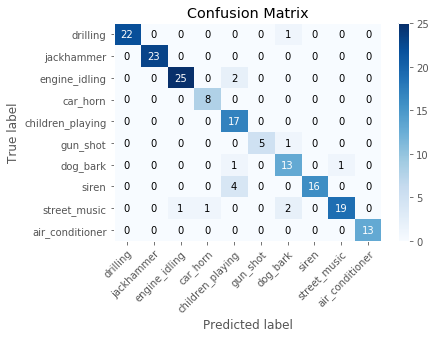

In [20]:
plot_confusion_matrix(cm)

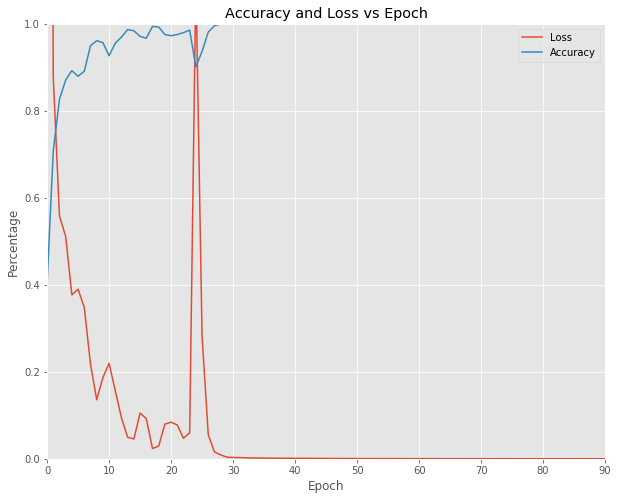

In [21]:
plot_history(history)

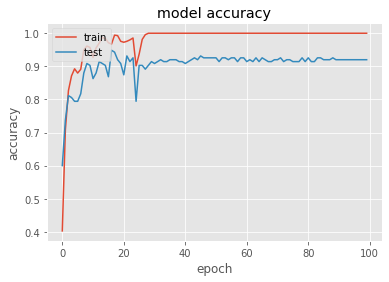

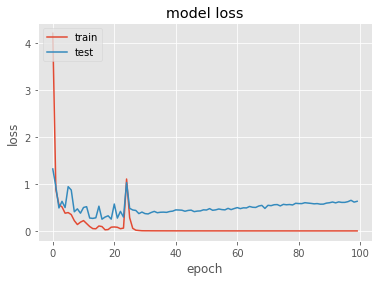

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#32, 32 lstm, w/ mel, chroma, zcr, mfcc, sp_centroid, sp_rolloff
#sgd 0.01
#***